## <center>  </center>

---


# <center> Personal Score Prediction </center>
## <center> Progetto di Programmazione di Applicazioni Data Intensive </center>
### <center> Analisi e addestramento di un modello di predizione basato su un dataset dei risultati medi per ogni stagione dei giocatori di NBA </center>
####<center> *Buzi Sajmir (0000975520), Ravaioli Marco (0000978817)* </center>


---



## Descrizione del contesto

- Verranno utilizzate delle Librerie per elaborare i dati forniti dal dataset tramite modelli di appensione
  - Per maneggiare i dati: `numpy`, `pandas`
  - Per disegnare grafici: `matplotlib`
  - Per elaborare il modello di apprendimento: `sklearn`

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler, MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

## Download del Dataset

- Si scarica dal sito di Kaggle: https://www.kaggle.com/ il dataset che ci interessa studiare
  - tramite l'API token: kaggle.json
  - si scarica il file "all_season.csv" da "justinas/nba-players-data"

In [ ]:
from google.colab import files
files.upload()                #caricare l'api token kaggle (kaggle.json)

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"marcoravaioli","key":"d2dd3c8135e13a559e5e04340a406e24"}'}

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d justinas/nba-players-data
!unzip nba-players-data.zip

seasons_raw = pd.read_csv("all_seasons.csv")

100% 564k/564k [00:00<00:00, 857kB/s]
100% 564k/564k [00:00<00:00, 857kB/s]
Archive:  nba-players-data.zip
  inflating: all_seasons.csv         


## Descrizione del Problema

- Il nostro intento è predire con sufficiente precisione statistiche medie della stagione di un giocatore con certe caratteristiche che restringono il campo di ricerca e che verranno spiegate successivamente.
- Prendiamo come stagione di riferimento il 2022/2023 per la valutazione del modello. Come dati di addestramento prendiamo le stagioni precedenti.

 Per eseguire una corretta analisi faremo uso di grafici e lo studio di variabili che permettano una predizione con minore errore.

- A priori sappiamo che alcuni risultati possono essere influenzati da fattori esterni che non sono espresse nel dataset (infortuni, squalifiche, ruolo del giocatore), è nostro impegno minimizzare fattori esterni tramite selezioni o elaborazione dei dati.


## Analisi esplorativa

- Si prende in considerazione un dataset dei giocatori che hanno partecipato al campionato di NBA in cui vengono raccolti sui dati medi o percentuali di caratteristiche del giocatore in una stagione.
  - il file si presenta in formato .csv separando i valori, appunto con una ","
  - raccoglie informazioni dalla stagione 1996-97 alla stagione 2022-23
  - i giocatori totali sono 2551 e gli attributi sono 21 per un totale di 12844 istanze di giocatori nei vari anni (alcuni ripetuti se hanno partecipato a più stagioni).

In [ ]:
seasons_raw.tail(3)

,Unnamed: 0,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,...,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season
12841,12841,John Collins,ATL,25.0,205.74,102.511792,Wake Forest,USA,2017,1,...,13.1,6.5,1.2,-0.2,0.035,0.180,0.168,0.593,0.052,2022-23
12842,12842,Jericho Sims,NYK,24.0,208.28,113.398000,Texas,USA,2021,2,...,3.4,4.7,0.5,-6.7,0.117,0.175,0.074,0.780,0.044,2022-23
12843,12843,JaMychal Green,GSW,33.0,205.74,102.965384,Alabama,USA,Undrafted,Undrafted,...,6.4,3.6,0.9,-8.2,0.087,0.164,0.169,0.650,0.094,2022-23


In [ ]:
seasons_raw.shape

(12844, 22)

In [ ]:
seasons_raw.isnull().sum(axis=0)

Unnamed: 0              0
player_name             0
team_abbreviation       0
age                     0
player_height           0
player_weight           0
college              1854
country                 0
draft_year              0
draft_round             0
draft_number            0
gp                      0
pts                     0
reb                     0
ast                     0
net_rating              0
oreb_pct                0
dreb_pct                0
usg_pct                 0
ts_pct                  0
ast_pct                 0
season                  0
dtype: int64

In [ ]:
seasons_raw.dtypes

Unnamed: 0             int64
player_name           object
team_abbreviation     object
age                  float64
player_height        float64
player_weight        float64
college               object
country               object
draft_year            object
draft_round           object
draft_number          object
gp                     int64
pts                  float64
reb                  float64
ast                  float64
net_rating           float64
oreb_pct             float64
dreb_pct             float64
usg_pct              float64
ts_pct               float64
ast_pct              float64
season                object
dtype: object

In [ ]:
seasons_raw.info(verbose=False, memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12844 entries, 0 to 12843
Columns: 22 entries, Unnamed: 0 to season
dtypes: float64(12), int64(2), object(8)
memory usage: 7.5 MB


- Si osservano il numero di valori unici per alcuni attributi presenti all'interno del dataset.

In [ ]:
max_len = max(len(x) for x in ["team_abbreviation", "college", "country", "player_name", "draft_number"])

for x in ["team_abbreviation", "college", "country", "player_name", "draft_number"]:
    print("{:<{width}}:\t{}".format(x, seasons_raw[x].nunique(), width=max_len))

team_abbreviation:	36
college          :	356
country          :	82
player_name      :	2551
draft_number     :	76


### Elaborazione del Dataset

- modifichiamo il tipo dei dati espressi nel dataframe per occupare meno memoria
  - si esprime con -1 la caratteristica di non aver fatto il draft, questo dopo verrà utilizzato per ottenere una variabile categorica

In [ ]:
seasons_raw['draft_year'] = seasons_raw['draft_year'].apply(lambda x: -1 if x == 'Undrafted' else int(x))
seasons_raw['draft_number'] = seasons_raw['draft_number'].apply(lambda x: -1 if x == 'Undrafted' else int(x))
seasons_raw['season'] = seasons_raw['season'].astype(str).str.split('-', expand=True)[0].astype(int)
seasons_raw['team_abbreviation'] = seasons_raw['team_abbreviation'].astype('category')
seasons_raw['college'] = seasons_raw['college'].astype('category')
seasons_raw['country'] = seasons_raw['country'].astype('category')

print(str(seasons_raw.dtypes) + "\n")
print(seasons_raw.info(verbose=False, memory_usage="deep"))

Unnamed: 0              int64
player_name            object
team_abbreviation    category
age                   float64
player_height         float64
player_weight         float64
college              category
country              category
draft_year              int64
draft_round            object
draft_number            int64
gp                      int64
pts                   float64
reb                   float64
ast                   float64
net_rating            float64
oreb_pct              float64
dreb_pct              float64
usg_pct               float64
ts_pct                float64
ast_pct               float64
season                  int64
dtype: object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12844 entries, 0 to 12843
Columns: 22 entries, Unnamed: 0 to season
dtypes: category(3), float64(12), int64(5), object(2)
memory usage: 3.3 MB
None


- Inseriamo il nome come indice
- Si tolgono le colonne che esprimono caratteristiche non significative

In [ ]:
seasons_all = seasons_raw.set_index("player_name")
seasons_all.drop(columns=['Unnamed: 0', 'draft_round'], inplace=True)
seasons_all.head(5)

,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_number,gp,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season
player_name,,,,,,,,,,,,,,,,,,,
Randy Livingston,HOU,22.0,193.04,94.800728,Louisiana State,USA,1996,42,64,3.9,1.5,2.4,0.3,0.042,0.071,0.169,0.487,0.248,1996
Gaylon Nickerson,WAS,28.0,190.50,86.182480,Northwestern Oklahoma,USA,1994,34,4,3.8,1.3,0.3,8.9,0.030,0.111,0.174,0.497,0.043,1996
George Lynch,VAN,26.0,203.20,103.418976,North Carolina,USA,1993,12,41,8.3,6.4,1.9,-8.2,0.106,0.185,0.175,0.512,0.125,1996
George McCloud,LAL,30.0,203.20,102.058200,Florida State,USA,1989,7,64,10.2,2.8,1.7,-2.7,0.027,0.111,0.206,0.527,0.125,1996
George Zidek,DEN,23.0,213.36,119.748288,UCLA,USA,1995,22,52,2.8,1.7,0.3,-14.1,0.102,0.169,0.195,0.500,0.064,1996


- Si tolgono le stagioni dei giocatori in cui hanno presenziato meno dei 3/5 delle partite
- Eliminiamo tutti i giocatori che non hanno giocato nel 2022

In [ ]:
max_pg = seasons_all['gp'].max()
seasons_gp = seasons_all[seasons_all['gp'] >= (max_pg / 5 * 3)]
seasons = seasons_gp.loc[seasons_gp[seasons_gp['season'] == 2022].index]

- Si considerano solo i giocatori che hanno giocato almeno 5 stagioni per avere più dati da confrontare.



In [ ]:
num_seasons = seasons.groupby('player_name')['season'].nunique()
veterans = num_seasons[num_seasons.values >= 5]
seasons = seasons.loc[veterans.index]
seasons = seasons.sort_values(by='season')
seasons.reset_index(inplace=True)
seasons.head(5)

,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_number,gp,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season
0,LeBron James,CLE,19.0,203.20,108.86208,NaN,USA,2003,1,79,20.9,5.5,5.9,-2.6,0.035,0.117,0.280,0.488,0.268,2003
1,LeBron James,CLE,20.0,203.20,108.86208,NaN,USA,2003,1,80,27.2,7.4,7.2,1.9,0.038,0.170,0.297,0.554,0.324,2004
2,Chris Paul,NOK,21.0,182.88,79.37860,Wake Forest,USA,2005,4,78,16.1,5.1,7.8,-3.9,0.025,0.147,0.220,0.546,0.378,2005
3,LeBron James,CLE,21.0,203.20,108.86208,NaN,USA,2003,1,79,31.4,7.0,6.6,4.2,0.026,0.171,0.336,0.568,0.315,2005
4,Rudy Gay,MEM,20.0,205.74,99.79024,Connecticut,USA,2006,8,78,10.8,4.5,1.3,-2.5,0.052,0.143,0.209,0.497,0.078,2006


Lista delle variabili:
- *team_abbrevation*: nome abbreviato della squadra in cui ha giocato in quella stagione
- *age*: età in quella stagione
- *player_height*: altezza
- *player_weight*: peso
- *college*: college di provenienza
- *country*: Paese d'origine del giocatore
- *draft_year*: anno in cui ha partecipato al draft
- *draft_number*: classifica del draft in cui ha partecipato
- *gp*: partite giocate
- *pts*: punti fatti di media
- *reb*: rimbalzi medi
- *ast*: assist medi
- *net_rating*: La differenza tra Offensive Rating individuale e Defensive Rating individuale: in altri termini è il contributo effettivo di un giocatore quando è in campo. Se il valore è maggiore di zero, la presenza in campo sarà positiva, altrimenti sarà negativa (concede più punti di quanti ne realizza).
- *oreb_pct*: rimbalzi offensivi percentuali
- *dreb_pct*: rimbalzi difensivi percentuali
- *usg_pct*: quanto il giocatore è stato reso partecipe nelle azioni mentre era in campo
- *ts_pct*: efficacia percentuale dei tiri liberi, da 2pt e da 3pt
- *ast_pct*: assist percentuali del giocatore mentre era in campo
- *season*: anno in cui inizia il campionato di quella stagione

In [ ]:
seasons.info(verbose=False, memory_usage="deep")
seasons.dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 993 entries, 0 to 992
Columns: 20 entries, player_name to season
dtypes: category(3), float64(12), int64(4), object(1)
memory usage: 238.8 KB


player_name            object
team_abbreviation    category
age                   float64
player_height         float64
player_weight         float64
college              category
country              category
draft_year              int64
draft_number            int64
gp                      int64
pts                   float64
reb                   float64
ast                   float64
net_rating            float64
oreb_pct              float64
dreb_pct              float64
usg_pct               float64
ts_pct                float64
ast_pct               float64
season                  int64
dtype: object

## Rappresentazione grafica dell'insieme

- I grafici a barre e torta a rappresentare le variabili categoriche

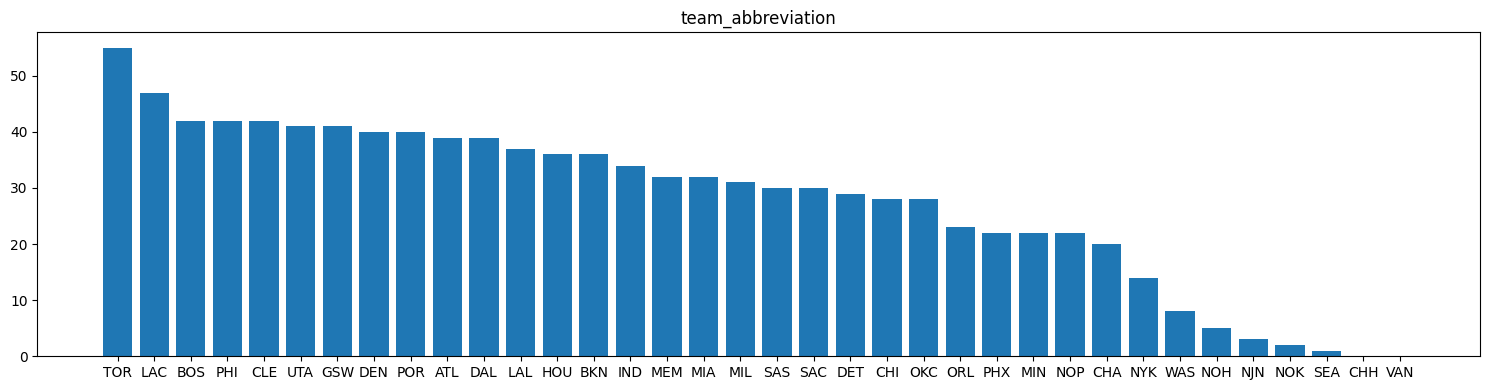

In [ ]:
plt.figure(figsize=(15, 4))
counts_team = seasons['team_abbreviation'].value_counts()
plt.bar(counts_team.index, counts_team)
plt.title('team_abbreviation')

plt.tight_layout()

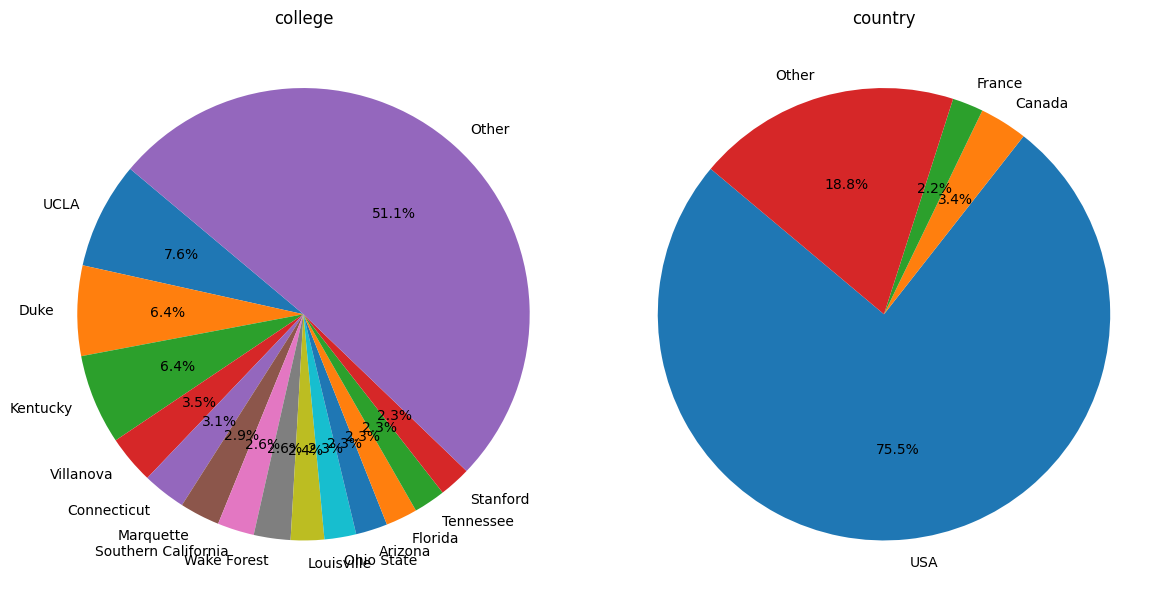

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

for ax, col in zip(axs.flatten(), ['college', 'country']):
    counts = seasons[col].value_counts()

    # Group categories with a percentage lower than 2% under the 'Other' category
    other = counts[counts / counts.sum() <= 0.022]
    counts['Other'] = other.sum()
    counts = counts.drop(other.index)

    ax.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140)
    ax.set_title(col)

plt.tight_layout()

  - si nota che i giocatori sono molto distribuiti tra i college di provenienza, per quanto riguarda la nazionalità è per la maggior parte americana

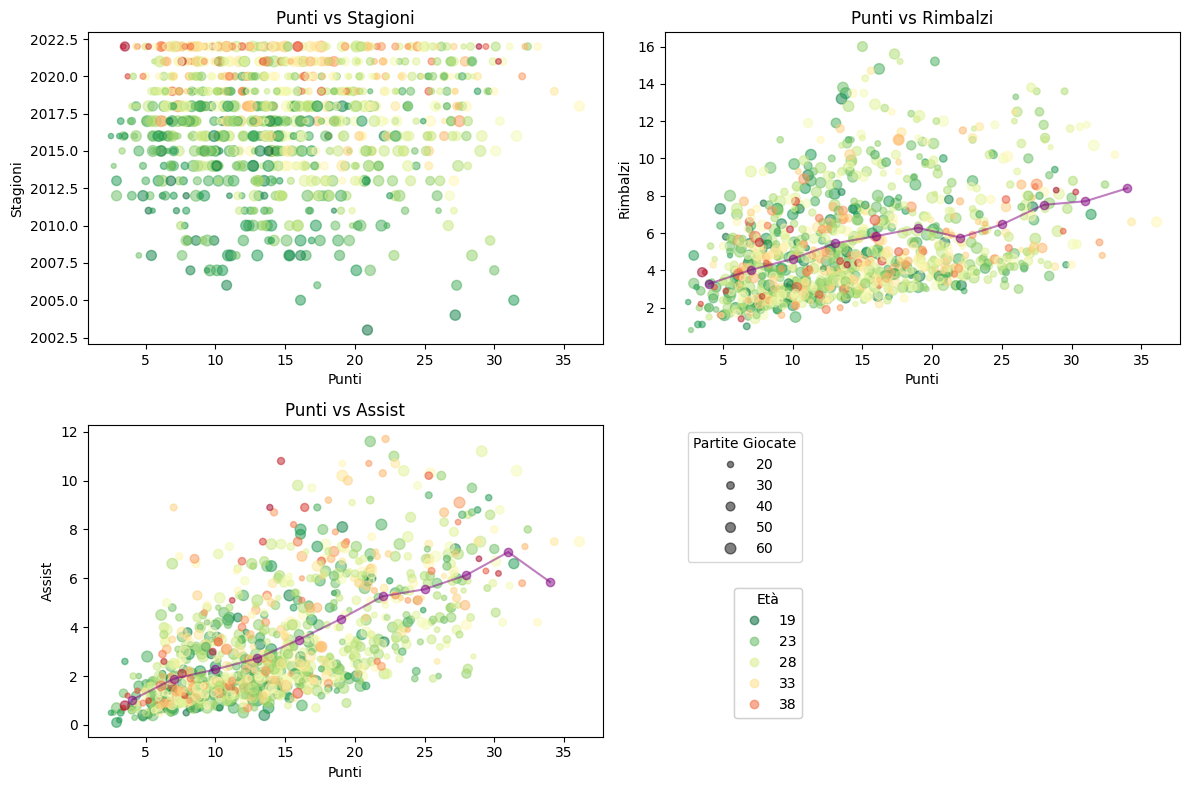

In [ ]:
def mean_by_pts(div, var):
  #div = points range, var = variable to compare
  bins = np.arange(seasons['pts'].min(), seasons['pts'].max(), div)
  avg_by_pts = seasons.groupby(pd.cut(seasons['pts'], bins=bins))[var].mean()
  avg_mid = [(x.left + x.right) / 2 for x in avg_by_pts.index]
  return avg_by_pts, avg_mid

def draw_scatter(X, y, label, title, xlabel, ylabel):
  scatter = plt.scatter(X, y, label=label, c=colors, s=sizes, alpha=0.5, cmap='RdYlGn_r')
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  return scatter

sizes = np.exp(seasons['gp'] / 20)
colors = (seasons['age'] / seasons['age'].max())

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
draw_scatter(seasons['pts'], seasons['season'], seasons['country'], 'Points vs Seasons', 'Points', 'Seasons')

plt.subplot(2, 2, 2)
draw_scatter(seasons['pts'], seasons['reb'], seasons['country'], 'Points vs Rebounce', 'Points', 'Rebounce')
avg_reb_by_pts, reb_mid = mean_by_pts(3, 'reb')
plt.plot(reb_mid, avg_reb_by_pts.values, color='purple', linestyle='-', marker='o', label='Average Rebounce', alpha=0.5)

plt.subplot(2, 2, 3)
scatter = draw_scatter(seasons['pts'], seasons['ast'], seasons['country'], 'Points vs Assist', 'Points', 'Assist')
avg_ast_by_pts, ast_mid = mean_by_pts(3, 'ast')
plt.plot(ast_mid, avg_ast_by_pts.values, color='purple', linestyle='-', marker='o', label='Average Assist', alpha=0.5)

legend2 = plt.legend(*scatter.legend_elements('sizes', num=6), title='Played Games', loc='upper right', bbox_to_anchor=(1.4, 1))
plt.gca().add_artist(legend2)

unique_ages = sorted(seasons['age'].unique())
sampled_ages = np.linspace(min(unique_ages), max(unique_ages), num=5, dtype=int)

legend1_labels = [f'{age}' for age in sampled_ages]
legend1 = plt.legend(handles=scatter.legend_elements('colors', num=6)[0], labels=legend1_labels, title='Età', loc='upper right', bbox_to_anchor=(1.4, 0.5))
plt.gca().add_artist(legend1)

plt.tight_layout()

- i grafici dimostrano che c'è un rapporto inversamente proporzionale tra il numero di partite giocate e l'età (osservando la forma e il colore dei punti si evince che più si è anziani meno partite si disputano)
- il rapporto tra Punti e Assist e tra Punti e Rimbalzi è circa lineare

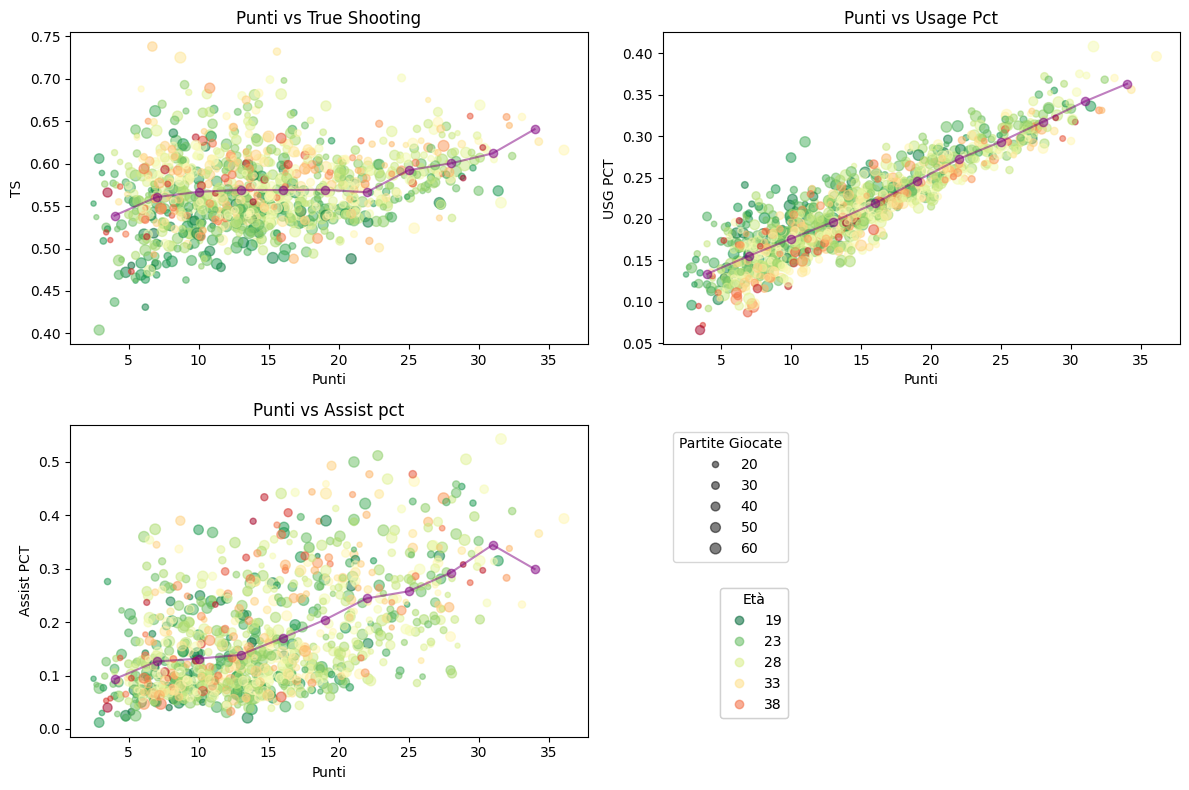

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
draw_scatter(seasons['pts'], seasons['ts_pct'], seasons['country'], 'Points vs True Shooting', 'Points', 'TS')
avg_ts_by_pts, ts_mid = mean_by_pts(3, 'ts_pct')
plt.plot(ts_mid, avg_ts_by_pts.values, color='purple', linestyle='-', marker='o', label='Media Assist', alpha=0.5)

plt.subplot(2, 2, 2)
draw_scatter(seasons['pts'], seasons['usg_pct'], seasons['country'], 'Points vs Usage Pct', 'Points', 'USG PCT')
avg_usg_by_pts, usg_mid = mean_by_pts(3, 'usg_pct')
plt.plot(usg_mid, avg_usg_by_pts.values, color='purple', linestyle='-', marker='o', label='Average Usage pct', alpha=0.5)

plt.subplot(2, 2, 3)
draw_scatter(seasons['pts'], seasons['ast_pct'], seasons['country'], 'Points vs Assist pct', 'Points', 'Assist PCT')
avg_astp_by_pts, astp_mid = mean_by_pts(3, 'ast_pct')
plt.plot(astp_mid, avg_astp_by_pts.values, color='purple', linestyle='-', marker='o', label='Average Assist pct', alpha=0.5)

legend2 = plt.legend(*scatter.legend_elements('sizes', num=6), title='Played games', loc='upper right', bbox_to_anchor=(1.4, 1))
plt.gca().add_artist(legend2)

unique_ages = sorted(seasons['age'].unique())
sampled_ages = np.linspace(min(unique_ages), max(unique_ages), num=5, dtype=int)

legend1_labels = [f'{age}' for age in sampled_ages]
legend1 = plt.legend(handles=scatter.legend_elements('colors', num=6)[0], labels=legend1_labels, title='Età', loc='upper right', bbox_to_anchor=(1.4, 0.5))
plt.gca().add_artist(legend1)


plt.tight_layout()

- Queste features hanno rapporto lineare con i punti medi

- Si osserva adesso se ci sono variazioni tra i risultati medi dei giocatori allo scorrere delle stagioni

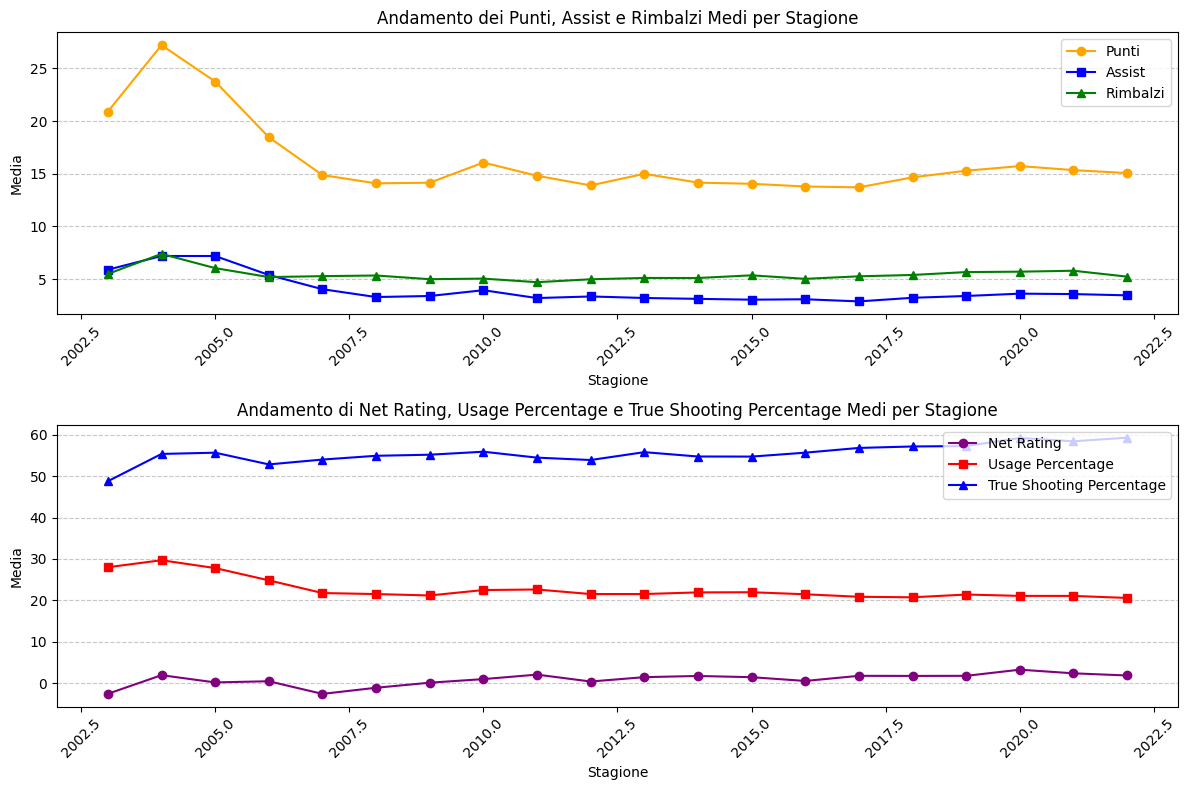

In [ ]:
avg_pts_by_season = seasons.groupby('season')['pts'].mean()
avg_ast_by_season = seasons.groupby('season')['ast'].mean()
avg_reb_by_season = seasons.groupby('season')['reb'].mean()
avg_net_rating_by_season = seasons.groupby('season')['net_rating'].mean()
avg_usg_pct_by_season = seasons.groupby('season')['usg_pct'].mean() * 100
avg_ts_pct_by_season = seasons.groupby('season')['ts_pct'].mean() * 100

plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)

avg_pts_by_season.plot(kind='line', marker='o', color='orange', linestyle='-', label='Points')
avg_ast_by_season.plot(kind='line', marker='s', color='blue', linestyle='-', label='Assist')
avg_reb_by_season.plot(kind='line', marker='^', color='green', linestyle='-', label='Rebounce')

plt.title('Trend of Points, Assists, and Rebounds Averages per Season')
plt.xlabel('Season')
plt.ylabel('Mean')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

plt.subplot(2, 1, 2)

avg_net_rating_by_season.plot(kind='line', marker='o', color='purple', linestyle='-', label='Net Rating')
avg_usg_pct_by_season.plot(kind='line', marker='s', color='red', linestyle='-', label='Usage Percentage')
avg_ts_pct_by_season.plot(kind='line', marker='^', color='blue', linestyle='-', label='True Shooting Percentage')

plt.title('Trend of Average Net Rating, Usage Percentage, and True Shooting Percentage per Season')
plt.xlabel('Season')
plt.ylabel('Mean')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

plt.tight_layout()

- come si può notare di seguito i primi anni hanno valori molto variabili perché sono pochi i giocatori tutt'ora in attività che hanno partecipato a quelle edizioni
- per il resto non si notano significative variazioni col passare delle stagioni, ciò vuole dire che non ci sarà un fattore che influenza l'andamento della feature nel tempo

2003    1
2004    1
2005    2
2006    3
2007    8
Name: season, dtype: int64

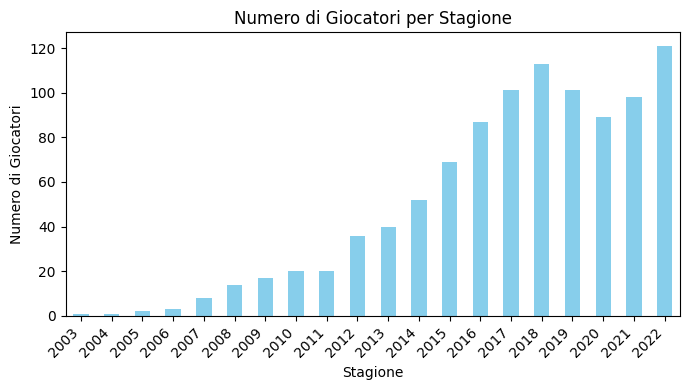

In [ ]:
plt.figure(figsize=(7, 4))
season_counts = seasons['season'].value_counts().sort_index()
season_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Players per Season')
plt.xlabel('Season')
plt.ylabel('Number of players')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

season_counts.head(5)

- Si rappresentano con un istogramma la frequenza dei punti medi nel 2022 dei giocatori

<Axes: ylabel='Frequency'>

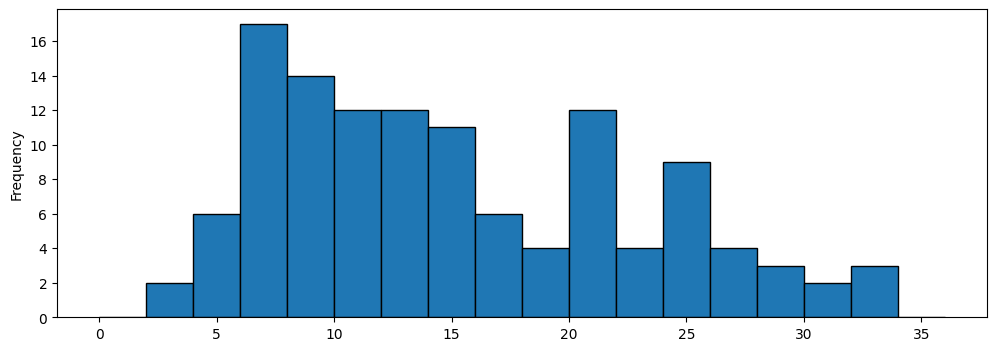

In [ ]:
seasons.loc[seasons['season']==2022, 'pts'].plot.hist(bins=range(0, int(seasons.loc[seasons['season']==2022, 'pts'].max()) + 4, 2), figsize=(12,4), edgecolor='black')

- Si noti come ci sia una distribuzione che inizia con una camapana Gaussiana ma che poi la fequenza aumenta verso la media punti più alta, a rappresentare l'alto numero di fuoriclasse che ospita il campionato

## Selezione delle feature

Adesso andremo a fare una suddivisione dei nostri dati i due sottocategorie, dati numerici e dati categorici.

In [ ]:
numeric_vars = ['age', 'player_height', 'player_weight', 'draft_year', 'gp', 'reb', 'ast', 'net_rating', 'oreb_pct', 'dreb_pct', 'usg_pct', 'ts_pct', 'ast_pct']
categorical_vars = ['college', 'country']

- si analizzano quali variabili tra quelle numeriche cambiano di più al variare del numero di punti medi fatti.

Text(0.5, 1.0, 'Correlazione')

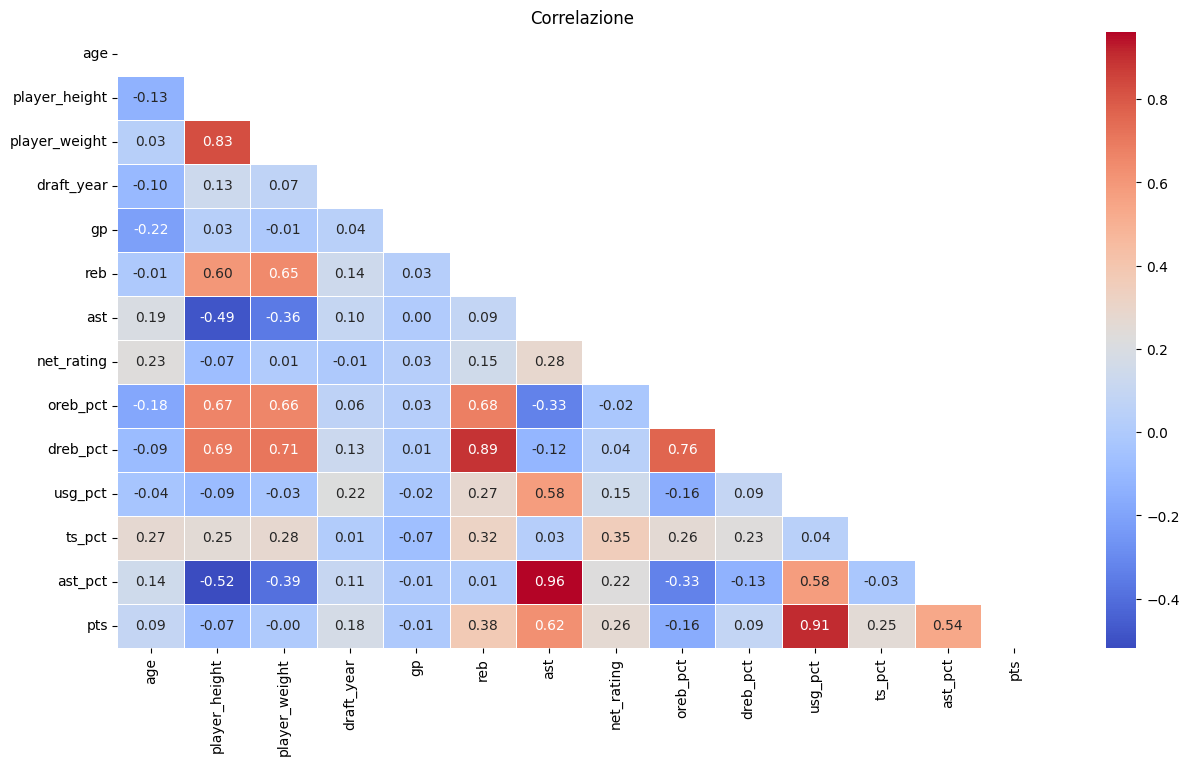

In [ ]:
import seaborn as sns

corr_matrix = seasons[numeric_vars + ['pts']].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
fig, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(corr_matrix, annot=True, mask=mask, cmap='coolwarm', linewidths=0.5, fmt=".2f", ax=ax)
ax.set_title('Correlation')

In [ ]:
abs(seasons[numeric_vars].corrwith(seasons['pts'])).sort_values(ascending=False)

usg_pct          0.907284
ast              0.623199
ast_pct          0.539882
reb              0.377749
net_rating       0.263587
ts_pct           0.253951
draft_year       0.175615
oreb_pct         0.160352
age              0.091842
dreb_pct         0.087029
player_height    0.072711
gp               0.007923
player_weight    0.000929
dtype: float64

- ci sono valori che hanno una forte correlazione con i punti, come usg_pct e assist, sia medi sia percentuali
- player_weight e gp sono ininfluenti, li rimuoveremo in quanto tali

In [ ]:
seasons.drop(['player_weight', 'gp'], axis=1, inplace=True)

In [ ]:
seasons.head(2)

,player_name,team_abbreviation,age,player_height,college,country,draft_year,draft_number,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season
0,LeBron James,CLE,19.0,203.2,None,USA,2003,1,20.9,5.5,5.9,-2.6,0.035,0.117,0.280,0.488,0.268,2003
1,LeBron James,CLE,20.0,203.2,None,USA,2003,1,27.2,7.4,7.2,1.9,0.038,0.170,0.297,0.554,0.324,2004


## Preparazione dei dati per l'addestramento

- La variabile draft_number non può essere usata come continua, infatti il valore -1 indica una categoria diversa (coloro che non hanno partecipato al draft) quindi si crea una variabile categorica che assume valore 0 per chi ha -1, 1 chi è stato scelto nelle prime 10 posizioni del draft, 2 chi nelle seguenti 10 e così via
- Come si è notato dai grafici a torta della sezione precedente il dato sulle nazionalità è molto sblianciato, quindi da quella si crea una variabile binaria *american*


In [ ]:
intervalli = list(range(-10, 51, 10))
etichette = list(range(len(intervalli) - 1))

seasons['draft_category'] = pd.cut(seasons['draft_number'], bins=intervalli, labels=etichette)
seasons['american'] = (seasons['country'] == 'USA') .astype(int)

In [ ]:
numeric_vars = ['pts', 'reb', 'ast', 'net_rating', 'oreb_pct', 'dreb_pct', 'usg_pct', 'ts_pct', 'ast_pct']
categoric_vars = ['draft_category']
binary_vars = ['american']

- si creano delle nuove variabili a partire da quelle con maggior correlazione con *pts*, ricavando dati che esprimono il valore e l'andamento delle variabili al passare delle stagioni per ogni giocatore,le nuove variabli create sono all'interno della funzione ***calculate_new_features*** .

In [ ]:
def calculate_trend(data):
    X = data.index.values.reshape(-1, 1)
    y = data.values.reshape(-1, 1)
    model = LinearRegression()
    model.fit(X, y)
    return model.coef_[0][0]

In [ ]:
def calculate_new_features(data):
    new_features = {}
    for column in data.columns:
        if column not in ['player_name', 'season']:
            feature_name = f'{column}_'
            feature_data = data[column]
            new_features[feature_name + 'mean'] = feature_data.mean()
            new_features[feature_name + 'std'] = feature_data.std()
            new_features[feature_name + 'variation'] = feature_data.max() - feature_data.min()
            new_features[feature_name + 'trend'] = calculate_trend(feature_data)
    return new_features

- Le statistiche a cui si fa riferimento escludono quelle della stagione di cui si vuole far la previsione, perché in quanto tale, esse non si possono sapere a priori
- Variabili come la nazionalità, la draft_category, età e altezza rimangono invariate anche nell'anno di cui si vuole predire il punteggio

In [ ]:
def generate_new_dataframe(original_dataframe, pred_season):
    grouped_data = original_dataframe[original_dataframe['season'] < pred_season].groupby('player_name')
    new_dataframe = pd.DataFrame()
    for player, data in grouped_data:
        new_features = calculate_new_features(data[numeric_vars])
        new_features['player_name'] = player
        new_features['pts'] = original_dataframe['pts'].loc[(original_dataframe['player_name'] == player) & (original_dataframe['season'] == pred_season)].values[0]
        new_features['american'] = original_dataframe['american'].loc[(original_dataframe['player_name'] == player) & (original_dataframe['season'] == pred_season)].values[0]
        new_features['draft_category'] = original_dataframe['draft_category'].loc[(original_dataframe['player_name'] == player) & (original_dataframe['season'] == pred_season)].values[0]
        new_features['age'] = original_dataframe['age'].loc[(original_dataframe['player_name'] == player) & (original_dataframe['season'] == pred_season)].values[0]
        new_features['player_height'] = original_dataframe['player_height'].loc[(original_dataframe['player_name'] == player) & (original_dataframe['season'] == pred_season)].values[0]
        new_dataframe = pd.concat([new_dataframe, pd.DataFrame(new_features, index=[0])], ignore_index=True)
        new_dataframe = new_dataframe[['player_name', 'pts'] + [col for col in new_dataframe.columns if col not in ['player_name', 'pts']]]
    return new_dataframe

In [ ]:
new_dataframe = generate_new_dataframe(seasons, 2022)

- Si estraggono le variabili più significative anche di questo dataframe

In [ ]:
best_feature = abs(new_dataframe.drop(columns=['pts']).corrwith(new_dataframe['pts'], numeric_only=True)).sort_values(ascending=False) .head(10)

unisco tutte le feature che mi interessano per la predizione

In [ ]:
selected_columns = best_feature.index.tolist() + categoric_vars + binary_vars
df = new_dataframe[selected_columns]
df.head(1)

,pts_mean,usg_pct_mean,usg_pct_trend,pts_trend,pts_std,ast_mean,pts_variation,ast_pct_mean,usg_pct_std,ast_trend,draft_category,american
0,14.15,0.2035,0.000012,0.006383,2.922841,2.616667,8.4,0.125167,0.022098,0.002209,1,1


In [ ]:
df.describe()

,pts_mean,usg_pct_mean,usg_pct_trend,pts_trend,pts_std,ast_mean,pts_variation,ast_pct_mean,usg_pct_std,ast_trend,draft_category,american
count,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000
mean,14.016849,0.208080,0.000037,0.010300,3.494361,3.064171,9.583471,0.161873,0.025350,0.002608,2.165289,0.743802
std,5.329842,0.051097,0.000092,0.011266,1.650291,1.933073,4.783101,0.089413,0.012474,0.002839,1.392522,0.438348
min,4.580000,0.094400,-0.000207,-0.012422,0.842120,0.600000,2.000000,0.048000,0.004796,-0.001728,0.000000,0.000000
25%,10.175000,0.168500,-0.000030,0.003006,2.191461,1.569231,5.900000,0.091800,0.017324,0.000723,1.000000,0.000000
50%,13.650000,0.208571,0.000034,0.008532,3.404507,2.360000,8.900000,0.131400,0.023028,0.002094,2.000000,1.000000
75%,16.618182,0.239818,0.000092,0.016535,4.588101,3.938462,12.800000,0.207600,0.030781,0.004006,3.000000,1.000000
max,27.227778,0.342250,0.000336,0.038376,8.332433,9.406250,26.200000,0.428438,0.071697,0.012976,5.000000,1.000000


In [ ]:
def plot_multiple(X, y, titles, nrows, ncols):
    fig, axes = plt.subplots(nrows, ncols, figsize=(8, 6))

    for i, ax in enumerate(axes.flat):
        if i < len(X):
            ax.scatter(X[i], y, color='blue', alpha=0.5)
            ax.set_title(titles[i])

    plt.tight_layout()
    plt.show()

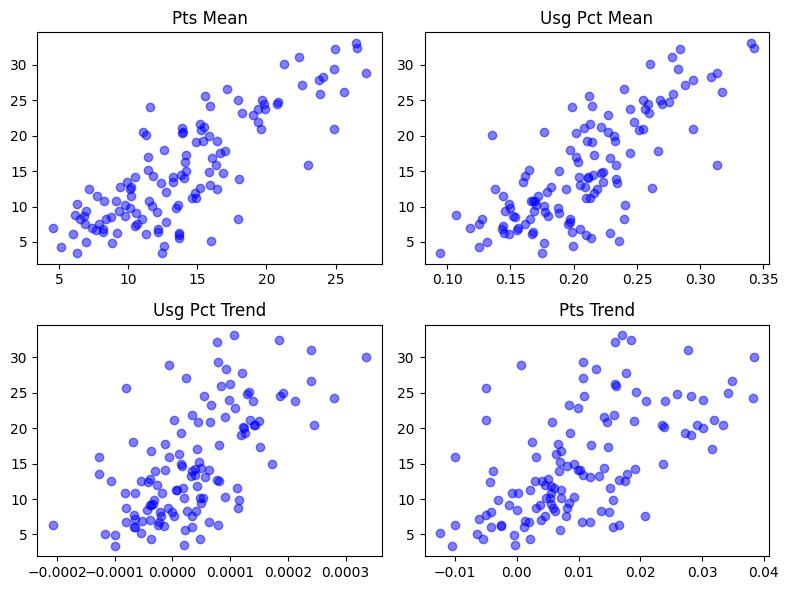

In [ ]:
X = [df['pts_mean'], df['usg_pct_mean'], df['usg_pct_trend'], df['pts_trend']]
y = new_dataframe['pts']
titles = ['Pts Mean', 'Usg Pct Mean', 'Usg Pct Trend', 'Pts Trend']

plot_multiple(X, y, titles, nrows=2, ncols=2)

## Addestramento Modelli
- Divisione dei dati in training e validation

In [ ]:
def create_val_train(X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_val, y_train, y_val

- preparazione di una Pipeline con ColumnTrasformer per codificare le variabili categoriche e uno scaler che stadardizzi le variabili
- Opzionalmente si può scegliere un grado per una Polynomial Feature
- I vari Parametri sono gestiti con una GridSearchCV

In [ ]:
def create_pipeline(model, polynomial_degree=None):
    column_transformer = ColumnTransformer(
        transformers=[
            ('num', ..., numeric_vars),
            ('cat', OneHotEncoder(), categoric_vars)
        ],
        remainder='passthrough'
    )

    transformations = [('preprocessor', column_transformer)]

    if polynomial_degree is not None:
        polynomial_transformer = PolynomialFeatures(degree=polynomial_degree, include_bias=False)
        transformations.append(('poly', polynomial_transformer))

    transformations.append(('model', model))

    return Pipeline(steps=transformations)

- Si addestra il modello di apprendimento della Pipeline con i dati elaborati

In [ ]:
def train_model(pipeline, X_train, y_train, param_grid=None):
    if param_grid is not None:
        kf = KFold(5, shuffle=True, random_state=42)
        pipeline = GridSearchCV(pipeline, param_grid, cv=kf)

        pipeline.fit(X_train, y_train)
    return pipeline

- Si valuta tramite diverse misure d'errore e di affinità il modello

In [ ]:
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))) * 100

In [ ]:
def print_eval(X, y, model):
    y_pred = model.predict(X)
    print(f"      MSE: {mean_squared_error(y, y_pred):12.4f}")
    print(f"R-squared: {r2_score(y, y_pred):12.4f}")
    print(f"    RMSPE: {rmspe(y, y_pred):12.4f}")

In [ ]:
def evaluate_model(X_train, X_test, y_train, y_test, pipeline):

    print("Model performance on training data:")
    print_eval(X_train, y_train, pipeline)
    print("--------------------------------------------")
    print("Model performance on test data:")
    print_eval(X_test, y_test, pipeline)
    print("--------------------------------------------")
    if isinstance(pipeline, GridSearchCV):
        print("Best parameters obtained from GridSearchCV:")
        print(pipeline.best_params_)
        print("--------------------------------------------")
    print(get_feature_importance(pipeline, numeric_vars, categoric_vars, binary_vars))

- Si osservano le features per importanza, sia se impattano positivamente sia negativamente, per essere più generici si estraggono le feature_importances_ per i RandomForest e i coef_ per le LinearRegression

In [ ]:
def get_feature_importance(pipeline, numeric_vars, categoric_vars, binary_vars):
    """Ottiene l'importanza delle feature dal modello."""
    pipeline = pipeline.best_estimator_
    model = pipeline.named_steps['model']
    if isinstance(model, RandomForestRegressor):
        importance = model.feature_importances_
        indices = np.argsort(importance)[::-1]
        feature_names = pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(input_features=categoric_vars)
        numeric_feature_names = numeric_vars
        binary_feature_names = binary_vars
        all_feature_names = np.concatenate((feature_names, numeric_feature_names, binary_feature_names))
        sorted_feature_names = all_feature_names[indices]
        feature_importance_list = list(zip(sorted_feature_names, importance[indices]))
    elif isinstance(model, LinearRegression):
        coefficients = model.coef_
        feature_names = pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(input_features=categoric_vars)
        numeric_feature_names = numeric_vars
        binary_feature_names = binary_vars
        all_feature_names = np.concatenate((feature_names, numeric_feature_names, binary_feature_names))
        feature_importance_list = list(zip(all_feature_names, coefficients))
    else:
        return None

    feature_importance_list = sorted(feature_importance_list, key=lambda x: x[1] if x[1] is not None else float('inf'), reverse=True)

    df_feature_importance = pd.DataFrame(feature_importance_list, columns=['Feature', 'Importance'])
    return df_feature_importance


In [ ]:
def train_and_evaluate_model(X, y, model, polynomial_degree=None, param_grid=None):
    X_train, X_val, y_train, y_val = create_val_train(X, y)
    pipeline = create_pipeline(model, polynomial_degree=None)
    pipeline = train_model(pipeline, X_train, y_train, param_grid)

    evaluate_model(X_train, X_val, y_train, y_val, pipeline)


    return pipeline

In [ ]:
numeric_vars = ['pts_mean', 'usg_pct_mean', 'usg_pct_trend', 'pts_trend', 'pts_std', 'ast_mean', 'pts_variation', 'ast_pct_mean', 'usg_pct_std', 'ast_trend']
categoric_vars = ['draft_category']
binary_vars = ['american']

- Per ogni modello si presenta un param_grid in cui si confrontano alcuni degli iperparametri e delle funzioni per ottenere la combinazione migliore

## LinearRegression

In [ ]:
model = LinearRegression()

param_grid = {
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), "passthrough"],
    'preprocessor__cat__drop': [None, "first"],
    'preprocessor__cat__sparse_output': [True, False],
    'model__fit_intercept': [True, False],
}

%time lrp = train_and_evaluate_model(df, new_dataframe['pts'], model, None, param_grid)

Prestazioni del modello sui dati di training:
      MSE:       9.2641
R-squared:       0.8479
    RMSPE:      30.6560
--------------------------------------------
Prestazioni del modello sui dati di test:
      MSE:       9.0828
R-squared:       0.8098
    RMSPE:      29.1189
--------------------------------------------
Migliori parametri ottenuti dalla GridSearchCV:
{'model__fit_intercept': False, 'preprocessor__cat__drop': 'first', 'preprocessor__cat__sparse_output': True, 'preprocessor__num': MinMaxScaler()}
--------------------------------------------
             Feature  Importance
0   draft_category_1   30.166647
1   draft_category_4   20.335288
2          pts_trend    8.725728
3      usg_pct_trend    1.886414
4            pts_std    1.753643
5       ast_pct_mean    0.009284
6           american   -0.483865
7           ast_mean   -0.505373
8      pts_variation   -0.993127
9        usg_pct_std   -1.168406
10         ast_trend   -1.280322
11      usg_pct_mean   -2.117499
12  draft

## Ridge

In [ ]:
model = Ridge()

param_grid = {
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), "passthrough"],
    'preprocessor__cat__drop': [None, "first"],
    'preprocessor__cat__sparse_output': [True, False],
    'model__alpha': [0.001, 0.01, 0.1, 1.0, 10.0],
    'model__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}

%time rp = train_and_evaluate_model(df, new_dataframe['pts'], model, None, param_grid)

Prestazioni del modello sui dati di training:
      MSE:       9.2938
R-squared:       0.8474
    RMSPE:      30.7135
--------------------------------------------
Prestazioni del modello sui dati di test:
      MSE:       8.8609
R-squared:       0.8145
    RMSPE:      24.2026
--------------------------------------------
Migliori parametri ottenuti dalla GridSearchCV:
{'model__alpha': 0.1, 'model__solver': 'sag', 'preprocessor__cat__drop': 'first', 'preprocessor__cat__sparse_output': True, 'preprocessor__num': MinMaxScaler()}
--------------------------------------------
None
CPU times: user 38.2 s, sys: 250 ms, total: 38.4 s
Wall time: 38.7 s


- Lasso

In [ ]:
from sklearn.linear_model import Lasso

model = Lasso()

param_grid = {
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), "passthrough"],
    'preprocessor__cat__drop': [None, "first"],
    'preprocessor__cat__sparse_output': [True, False],
    'model__alpha': [0.001, 0.01, 0.1, 1.0, 10.0],
    'model__max_iter': [100, 500, 1000],
    'model__tol': [0.0001, 0.001, 0.01]
}

%time lp = train_and_evaluate_model(df, new_dataframe['pts'], model, None, param_grid)

Prestazioni del modello sui dati di training:
      MSE:       9.5886
R-squared:       0.8426
    RMSPE:      31.7311
--------------------------------------------
Prestazioni del modello sui dati di test:
      MSE:       8.7590
R-squared:       0.8166
    RMSPE:      26.3760
--------------------------------------------
Migliori parametri ottenuti dalla GridSearchCV:
{'model__alpha': 0.1, 'model__max_iter': 100, 'model__tol': 0.001, 'preprocessor__cat__drop': None, 'preprocessor__cat__sparse_output': True, 'preprocessor__num': StandardScaler()}
--------------------------------------------
None
CPU times: user 42.9 s, sys: 274 ms, total: 43.2 s
Wall time: 44.5 s


## ElasticNet

In [ ]:
from sklearn.linear_model import ElasticNet

model = ElasticNet()

param_grid = {
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), "passthrough"],
    'preprocessor__cat__drop': [None, "first"],
    'preprocessor__cat__sparse_output': [True, False],
    'model__alpha': [0.001, 0.01, 0.1, 1.0, 10.0],
    'model__max_iter': [100, 500, 1000],
    'model__tol': [0.0001, 0.001, 0.01]
}

%time enp = train_and_evaluate_model(df, new_dataframe['pts'], model, None, param_grid)


Prestazioni del modello sui dati di training:
      MSE:      10.0004
R-squared:       0.8358
    RMSPE:      33.2206
--------------------------------------------
Prestazioni del modello sui dati di test:
      MSE:       9.0001
R-squared:       0.8116
    RMSPE:      25.5686
--------------------------------------------
Migliori parametri ottenuti dalla GridSearchCV:
{'model__alpha': 0.1, 'model__max_iter': 100, 'model__tol': 0.01, 'preprocessor__cat__drop': None, 'preprocessor__cat__sparse_output': True, 'preprocessor__num': StandardScaler()}
--------------------------------------------
None
CPU times: user 41 s, sys: 267 ms, total: 41.2 s
Wall time: 41.5 s


## Support Vector Regression

In [ ]:
from sklearn.svm import SVR

model = SVR()

param_grid = {
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), "passthrough"],
    'preprocessor__cat__drop': [None, "first"],
    'preprocessor__cat__sparse_output': [True, False],
    'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'model__C': [0.1, 1, 10, 100],
    'model__epsilon': [0.1, 0.2, 0.5, 1.0],
}

%time train_and_evaluate_model(df, new_dataframe['pts'], model, None, param_grid)

Prestazioni del modello sui dati di training:
      MSE:      10.2341
R-squared:       0.8320
    RMSPE:      33.1251
--------------------------------------------
Prestazioni del modello sui dati di test:
      MSE:       9.9882
R-squared:       0.7909
    RMSPE:      25.6200
--------------------------------------------
Migliori parametri ottenuti dalla GridSearchCV:
{'model__C': 1, 'model__epsilon': 0.5, 'model__kernel': 'linear', 'preprocessor__cat__drop': None, 'preprocessor__cat__sparse_output': True, 'preprocessor__num': StandardScaler()}
--------------------------------------------
None
CPU times: user 1min 17s, sys: 313 ms, total: 1min 17s
Wall time: 1min 19s


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Ellipsis,
                                                                         ['pts_mean',
                                                                          'usg_pct_mean',
                                                                          'usg_pct_trend',
                                                                          'pts_trend',
                                                                          'pts_std',
                                                                          'ast_mean',
                                                                          'pts_variation',
                                                                          'ast_pct_mean',
                                                                          'usg_pct_std',
                                                                          'ast_trend']),
                                                                        ('cat',
                                                                         OneHotEncoder(),
                                                                         ['draft_category'])])),
                                       ('model', SVR())]),
             param_grid={'model__C': [0.1, 1, 10, 100],
                         'model__epsilon': [0.1, 0.2, 0.5, 1.0],
                         'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                         'preprocessor__cat__drop': [None, 'first'],
                         'preprocessor__cat__sparse_output': [True, False],
                         'preprocessor__num': [StandardScaler(), MinMaxScaler(),
                                               'passthrough']})

## Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor()

param_grid = {
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), "passthrough"],
    'preprocessor__cat__drop': [None, "first"],
    'preprocessor__cat__sparse_output': [True, False],
    'model__criterion': ['mse', 'friedman_mse', 'mae'],
    'model__splitter': ['best', 'random'],
    'model__max_depth': [None, 10, 20, 30],
    'model__max_features': ['auto', 'sqrt', 'log2']
}

%time train_and_evaluate_model(df, new_dataframe['pts'], model, None, param_grid)

Prestazioni del modello sui dati di training:
      MSE:       0.0000
R-squared:       1.0000
    RMSPE:       0.0000
--------------------------------------------
Prestazioni del modello sui dati di test:
      MSE:      39.9484
R-squared:       0.1636
    RMSPE:      54.6695
--------------------------------------------
Migliori parametri ottenuti dalla GridSearchCV:
{'model__criterion': 'friedman_mse', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__splitter': 'best', 'preprocessor__cat__drop': 'first', 'preprocessor__cat__sparse_output': False, 'preprocessor__num': StandardScaler()}
--------------------------------------------
None
CPU times: user 48 s, sys: 406 ms, total: 48.4 s
Wall time: 48.8 s


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Ellipsis,
                                                                         ['pts_mean',
                                                                          'usg_pct_mean',
                                                                          'usg_pct_trend',
                                                                          'pts_trend',
                                                                          'pts_std',
                                                                          'ast_mean',
                                                                          'pts_variation',
                                                                          'ast_pct_mean',
                                                                          'usg_pct_std',
                                                                          'ast_trend']),
                                                                        ('cat',
                                                                         OneHotEncoder(),
                                                                         ['draft_categor...
                                       ('model', DecisionTreeRegressor())]),
             param_grid={'model__criterion': ['mse', 'friedman_mse', 'mae'],
                         'model__max_depth': [None, 10, 20, 30],
                         'model__max_features': ['auto', 'sqrt', 'log2'],
                         'model__splitter': ['best', 'random'],
                         'preprocessor__cat__drop': [None, 'first'],
                         'preprocessor__cat__sparse_output': [True, False],
                         'preprocessor__num': [StandardScaler(), MinMaxScaler(),
                                               'passthrough']})

## Random Forest
- Attenzione l'esecuzione può impiegare molto tempo prima di essere completata

In [ ]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()

param_grid = {
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), "passthrough"],
    'preprocessor__cat__drop': [None, "first"],
    'preprocessor__cat__sparse_output': [True, False],
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__bootstrap': [True, False]
}

%time train_and_evaluate_model(df, new_dataframe['pts'], model, None, param_grid)


Prestazioni del modello sui dati di training:
      MSE:       2.6299
R-squared:       0.9568
    RMSPE:      18.5639
--------------------------------------------
Prestazioni del modello sui dati di test:
      MSE:      21.2362
R-squared:       0.5554
    RMSPE:      36.2495
--------------------------------------------
Migliori parametri ottenuti dalla GridSearchCV:
{'model__bootstrap': True, 'model__max_depth': 10, 'model__min_samples_leaf': 1, 'model__min_samples_split': 5, 'model__n_estimators': 50, 'preprocessor__cat__drop': 'first', 'preprocessor__cat__sparse_output': False, 'preprocessor__num': 'passthrough'}
--------------------------------------------
             Feature  Importance
0   draft_category_1    0.577251
1   draft_category_4    0.122484
2   draft_category_2    0.120787
3   draft_category_3    0.093138
4      usg_pct_trend    0.018382
5       usg_pct_mean    0.015172
6   draft_category_5    0.012410
7            pts_std    0.011768
8           pts_mean    0.009847
9

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Ellipsis,
                                                                         ['pts_mean',
                                                                          'usg_pct_mean',
                                                                          'usg_pct_trend',
                                                                          'pts_trend',
                                                                          'pts_std',
                                                                          'ast_mean',
                                                                          'pts_variation',
                                                                          'ast_pct_mean',
                                                                          'usg_pct_std',
                                                                          'ast_trend']),
                                                                        ('cat',
                                                                         OneHotEncoder(),
                                                                         ['draft_categor...
                                       ('model', RandomForestRegressor())]),
             param_grid={'model__bootstrap': [True, False],
                         'model__max_depth': [None, 10, 20],
                         'model__min_samples_leaf': [1, 2, 4],
                         'model__min_samples_split': [2, 5, 10],
                         'model__n_estimators': [50, 100, 200],
                         'preprocessor__cat__drop': [None, 'first'],
                         'preprocessor__cat__sparse_output': [True, False],
                         'preprocessor__num': [StandardScaler(), MinMaxScaler(),
                                               'passthrough']})

# K-Nearest Neighbors Regression

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

model = KNeighborsRegressor()

param_grid = {
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), "passthrough"],
    'preprocessor__cat__drop': [None, "first"],
    'preprocessor__cat__sparse_output': [True, False],
    'model__n_neighbors': [3, 5, 10, 20],
    'model__weights': ['uniform', 'distance'],
    'model__p': [1, 2]
}

%time train_and_evaluate_model(df, new_dataframe['pts'], model, None, param_grid)


Prestazioni del modello sui dati di training:
      MSE:       0.0000
R-squared:       1.0000
    RMSPE:       0.0000
--------------------------------------------
Prestazioni del modello sui dati di test:
      MSE:      19.7135
R-squared:       0.5872
    RMSPE:      33.6232
--------------------------------------------
Migliori parametri ottenuti dalla GridSearchCV:
{'model__n_neighbors': 5, 'model__p': 2, 'model__weights': 'distance', 'preprocessor__cat__drop': None, 'preprocessor__cat__sparse_output': True, 'preprocessor__num': StandardScaler()}
--------------------------------------------
None
CPU times: user 22.2 s, sys: 195 ms, total: 22.4 s
Wall time: 17.2 s


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Ellipsis,
                                                                         ['pts_mean',
                                                                          'usg_pct_mean',
                                                                          'usg_pct_trend',
                                                                          'pts_trend',
                                                                          'pts_std',
                                                                          'ast_mean',
                                                                          'pts_variation',
                                                                          'ast_pct_mean',
                                                                          'usg_pct_std',
                                                                          'ast_trend']),
                                                                        ('cat',
                                                                         OneHotEncoder(),
                                                                         ['draft_category'])])),
                                       ('model', KNeighborsRegressor())]),
             param_grid={'model__n_neighbors': [3, 5, 10, 20],
                         'model__p': [1, 2],
                         'model__weights': ['uniform', 'distance'],
                         'preprocessor__cat__drop': [None, 'first'],
                         'preprocessor__cat__sparse_output': [True, False],
                         'preprocessor__num': [StandardScaler(), MinMaxScaler(),
                                               'passthrough']})

## Gradient Boosting Regression

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor()

param_grid = {
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), "passthrough"],
    'preprocessor__cat__drop': [None, "first"],
    'preprocessor__cat__sparse_output': [True, False],
    'model__n_estimators': [50, 100, 200],
    'model__learning_rate': [0.01, 0.1, 0.5],
    'model__max_depth': [3, 5, 10],
}

%time train_and_evaluate_model(df, new_dataframe['pts'], model, None, param_grid)


Prestazioni del modello sui dati di training:
      MSE:       0.0000
R-squared:       1.0000
    RMSPE:       0.0037
--------------------------------------------
Prestazioni del modello sui dati di test:
      MSE:      19.6375
R-squared:       0.5888
    RMSPE:      32.6169
--------------------------------------------
Migliori parametri ottenuti dalla GridSearchCV:
{'model__learning_rate': 0.5, 'model__max_depth': 3, 'model__n_estimators': 100, 'preprocessor__cat__drop': None, 'preprocessor__cat__sparse_output': True, 'preprocessor__num': MinMaxScaler()}
--------------------------------------------
None
CPU times: user 2min 52s, sys: 469 ms, total: 2min 53s
Wall time: 2min 54s


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Ellipsis,
                                                                         ['pts_mean',
                                                                          'usg_pct_mean',
                                                                          'usg_pct_trend',
                                                                          'pts_trend',
                                                                          'pts_std',
                                                                          'ast_mean',
                                                                          'pts_variation',
                                                                          'ast_pct_mean',
                                                                          'usg_pct_std',
                                                                          'ast_trend']),
                                                                        ('cat',
                                                                         OneHotEncoder(),
                                                                         ['draft_category'])])),
                                       ('model', GradientBoostingRegressor())]),
             param_grid={'model__learning_rate': [0.01, 0.1, 0.5],
                         'model__max_depth': [3, 5, 10],
                         'model__n_estimators': [50, 100, 200],
                         'preprocessor__cat__drop': [None, 'first'],
                         'preprocessor__cat__sparse_output': [True, False],
                         'preprocessor__num': [StandardScaler(), MinMaxScaler(),
                                               'passthrough']})

## Extreme Gradient Boosting
- Richiede tempo per essere eseguito

In [ ]:
from xgboost import XGBRegressor

model = XGBRegressor()

param_grid = {
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), "passthrough"],
    'preprocessor__cat__drop': [None, "first"],
    'preprocessor__cat__sparse_output': [True, False],
    'model__n_estimators': [100, 300, 500],
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.01, 0.05, 0.1]
}

%time train_and_evaluate_model(df, new_dataframe['pts'], model, None, param_grid)


Prestazioni del modello sui dati di training:
      MSE:       0.0931
R-squared:       0.9985
    RMSPE:       3.0362
--------------------------------------------
Prestazioni del modello sui dati di test:
      MSE:      18.9166
R-squared:       0.6039
    RMSPE:      31.5166
--------------------------------------------
Migliori parametri ottenuti dalla GridSearchCV:
{'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 300, 'preprocessor__cat__drop': None, 'preprocessor__cat__sparse_output': True, 'preprocessor__num': StandardScaler()}
--------------------------------------------
None
CPU times: user 8min 41s, sys: 9.29 s, total: 8min 50s
Wall time: 5min 7s


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Ellipsis,
                                                                         ['pts_mean',
                                                                          'usg_pct_mean',
                                                                          'usg_pct_trend',
                                                                          'pts_trend',
                                                                          'pts_std',
                                                                          'ast_mean',
                                                                          'pts_variation',
                                                                          'ast_pct_mean',
                                                                          'usg_pct_std',
                                                                          'ast_trend']),
                                                                        ('cat',
                                                                         OneHotEncoder(),
                                                                         ['draft_categor...
                                                     n_estimators=None,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     random_state=None, ...))]),
             param_grid={'model__learning_rate': [0.01, 0.05, 0.1],
                         'model__max_depth': [3, 5, 7],
                         'model__n_estimators': [100, 300, 500],
                         'preprocessor__cat__drop': [None, 'first'],
                         'preprocessor__cat__sparse_output': [True, False],
                         'preprocessor__num': [StandardScaler(), MinMaxScaler(),
                                               'passthrough']})

In [ ]:
!pip install catboost
from catboost import CatBoostRegressor

model = CatBoostRegressor(verbose=False)

param_grid = {
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), "passthrough"],
    'preprocessor__cat__drop': [None, "first"],
    'preprocessor__cat__sparse_output': [True, False],
    'model__iterations': [100, 200, 500],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__depth': [4, 6, 8],
}

%time cbp = train_and_evaluate_model(df, new_dataframe['pts'], model, None, param_grid)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 5.1 MB/s eta 0:00:00
Prestazioni del modello sui dati di training:
      MSE:       0.1373
R-squared:       0.9977
    RMSPE:       3.8920
--------------------------------------------
Prestazioni del modello sui dati di test:
      MSE:      15.6846
R-squared:       0.6716
    RMSPE:      26.5085
--------------------------------------------
Migliori parametri ottenuti dalla GridSearchCV:
{'model__depth': 4, 'model__iterations': 500, 'model__learning_rate': 0.05, 'preprocessor__cat__drop': None, 'preprocessor__cat__sparse_output': True, 'preprocessor__num': MinMaxScaler()}
--------------------------------------------
None
CPU times: user 18min 34s, sys: 1min 16s, total: 19min 51s
Wall time: 13min 5s


In [ ]:
pred_players = ["Al Horford", "LeBron James", "Luka Doncic", "Nikola Jokic"]

In [ ]:
indici = new_dataframe[new_dataframe['player_name'].isin(pred_players)].index.tolist()

infos = df.loc[indici]
pred = lrp.predict(infos)
real_pts = new_dataframe[new_dataframe['player_name'].isin(pred_players)]

In [ ]:
punteggi_reali_dict = real_pts.set_index('player_name')['pts'].to_dict()
print("Player Name     | Predicted Score    | Actual Score (2022)")
print("-" * 70)
for player, predetto in zip(pred_players, pred):
    punteggio_reale = punteggi_reali_dict.get(player, "Actual Score Unavailable")
    print(f"{player.ljust(15)} | {f'{predetto:.2f}'.ljust(18)} | {str(punteggio_reale)}")

Nome giocatore  | Punteggio Predetto | Punteggio Reale (2022)
----------------------------------------------------------------------
Al Horford      | 12.17              | 9.8
LeBron James    | 27.36              | 28.9
Luka Doncic     | 33.40              | 32.4
Nikola Jokic    | 25.26              | 24.5


##Conclusioni finali

Come possiamo notare dall'esempio qua sopra utilizzando lpr come predict il nostro modello di predizione funziona come ci aspettavamo,ovviamente ci sono fattori esterni ce possono influenzare queste tipologie di predizioni come infortuni,squalifiche ecc.. abbiamo cercato oltre di prendere i dati numerici già in possesso di catturare altri dati che abbiamo creato noi dalla fusione dei dati già esistenti , facendo ciò abbiamo ottimizzato la soluzione finale.Abbiamo cercato di utilizzare più modelli possibile di predizione dal più basilare la **regressione lineare** al **extreme gradient boosting** ovviamente lo score di predizione varia da modello a modello.
Come si può notare abbiamo fatto utilizzo di molte funzioni , la principale motivazione è che se in un futuro il dataset dovesse aumentare e bisogna prendere in considerazione altri dati da predirre sarà molto più facile eseguire le varie modifiche.I dati dai noi studiati sono per puro studio accademico ma ovviamente questi modelli sono riusabili nella vita quotidiana per eseguire varie tipologie di predizioni dalle più semplici a quelle più difficili dal punto di vista computazionale.
Il risultato ottenuto dato la complessità del problema è buono e siamo soddisfatti del lavoro ottenuto.



- Come possiamo notare dall'esempio di cui sopra utilizzando lpr come predict il nostro modello di predizione funziona come ci aspettavamo. Ovviamente ci sono fattori esterni che possono influenzare queste tipologie di predizioni, come infortuni, squalifiche, ecc.
- Abbiamo cercato di prendere in considerazione non solo i dati numerici già in possesso, ma anche di catturare altri dati che abbiamo creato dalla fusione dei dati già esistenti. Facendo ciò, abbiamo ottimizzato la soluzione finale.
Abbiamo utilizzato diversi modelli di predizione, dalla regressione lineare all'extreme gradient boosting. È importante notare che lo score di predizione può variare da modello a modello.
- Abbiamo fatto ampio uso di funzioni, la principale motivazione è che, se in futuro il dataset dovesse aumentare e si rendesse necessario prendere in considerazione altri dati da predire, sarà molto più facile eseguire le varie modifiche.
- I dati che abbiamo studiato sono per puro scopo accademico, ma i modelli di predizione sviluppati si sono dimostrati affidabili anche nella realtà per eseguire predizioni nell'ambito di studio del caso proposto.
- Il risultato ottenuto, data la complessità del problema, è buono e siamo soddisfatti del lavoro svolto.